In [66]:
import os
import pandas as pd
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import glob
import pickle

PATH_HEAD = r"C:\Users\yana\Desktop\github\parametric_portfolio_boosting\ppboost"
os.chdir(PATH_HEAD)
folder_path = os.path.join(PATH_HEAD, r"Result\simulation\220131_022201\all_result.pkl")

In [67]:
from ppopt.utils.visualize import Visualizer

In [68]:
with open(folder_path, 'rb') as f:
    all_result = pickle.load(f)

output = all_result["output"]
set_pattern = list(output.keys())

In [69]:
def plot_lrp(start, end, port_lrp_dict, data_type, factor_category_dict):
    def extract_lrp(start, end, port_lrp_dict, data_type):
        dict_selected = port_lrp_dict[data_type]
        term_candidate = [i for i in dict_selected.keys() if i != "all"]
        term_selected = [i for i in term_candidate if (pd.to_datetime(i)>=start)&(pd.to_datetime(i)<=end)]
        df_lrp = 0
        for term in term_selected:
            df_lrp += dict_selected[term]
        df_lrp /= len(term_selected)
        
        return df_lrp    
    
    def make_factor_color(factor_category_dict):
        factor_category_unique = sorted(list(set(factor_category_dict.values())))
        color_list = px.colors.qualitative.Light24
        assert len(factor_category_unique) <= len(color_list)
        category_color = {category: color_list[i] for i, category in enumerate(factor_category_unique)}
        factor_color_dict = {feature: category_color[category] for feature, category in factor_category_dict.items()}
        
        return factor_color_dict
    
    df_lrp = extract_lrp(start, end, port_lrp_dict, data_type)    
    factor_color_dict = make_factor_color(factor_category_dict)
    
    fig = go.Figure()
    port_num = df_lrp.shape[0]

    fig = make_subplots(
        rows=port_num-1,
        cols=2,
        shared_xaxes="all",
        specs=[
            [{"rowspan": port_num - 1}, {}]] + [[None, {}] for _ in range(port_num - 2)],
        subplot_titles=(list(df_lrp.index)),
    )

    fig.update_layout(
        autosize=False,
        width=1300,
        height=900,
    )

    for port_id in range(port_num):
        if port_id == 0:
            row = port_id + 1
            col = 1
        else:
            row = port_id
            col = 2
        x = list(df_lrp.columns)
        y = df_lrp.iloc[port_id, :]
        color_x = [factor_color_dict[factor] for factor in x]
        fig.add_trace(
            go.Bar(
                x=x,
                y=list(y),
                marker_color=color_x,
                text=list(factor_category_dict.values()),                
                name=list(df_lrp.index)[port_id],
            ),
            row=row,
            col=col,
        )
        try:
            fig.add_annotation(
                x=y.idxmax(),
                y=y.max(),
                text=y.idxmax(),
                showarrow=True,
                arrowhead=1,
                row=row,
                col=col,
            )
        except Exception as e:
            print(e)
            pass
        
    fig.update_layout(
        title=dict(
            text="<b>[" + data_type + "]" + " <b>" + start.strftime("%y/%m") + " - <b>"+ str(end.strftime("%y/%m")),
            font=dict(size=26, color="grey"),
            y=0.95,
        ),
        showlegend=False,
    )
    fig.update_xaxes(matches="x")

    return fig

In [70]:
##### input
port_lrp_dict = output["sim6"]["port_lrp"]
print(port_lrp_dict.keys())
data_type = "to_None_tr_None"
print(port_lrp_dict[data_type].keys())
import datetime as dt
start = dt.datetime(2021, 9, 1)
end = dt.datetime(2022, 1, 31)
factor_category_dict = {
    "I_0": "type_I0",
    "I_1": "type_I0",
    "I_2": "type_I1",    
    "I_3": "type_I2",
    }
######

term_candidate = [i for i in port_lrp_dict[data_type].keys() if i != "all"]
fig = plot_lrp(start, end, port_lrp_dict, data_type, factor_category_dict)

dict_keys(['train', 'to_None_tr_None', 'to_0.02_tr_0.1'])
dict_keys([Timestamp('2020-11-28 00:00:00'), Timestamp('2020-12-28 00:00:00'), Timestamp('2021-01-28 00:00:00'), Timestamp('2021-02-28 00:00:00'), Timestamp('2021-03-30 00:00:00'), Timestamp('2021-04-30 00:00:00'), Timestamp('2021-05-30 00:00:00'), Timestamp('2021-06-30 00:00:00'), Timestamp('2021-07-30 00:00:00'), Timestamp('2021-08-30 00:00:00'), Timestamp('2021-09-30 00:00:00'), Timestamp('2021-10-30 00:00:00'), Timestamp('2021-11-30 00:00:00'), Timestamp('2021-12-31 00:00:00'), Timestamp('2022-01-31 00:00:00'), 'all'])


In [73]:
def plot_return(df_port_org, start, end, data_type):
    df_port = df_port_org.loc[(df_port_org.index>=start)&(df_port_org.index<=end), :].cumsum()
    hidden_name = [i for i in df_port.columns if "hidden" in i]

    fig = go.Figure()
    fig = make_subplots(
        rows=2,
        cols=1,
        specs=[[{"secondary_y": True}], [{"secondary_y": True}]],
    )

    fig.update_layout(
        autosize=False,
        width=1300,
        height=900,
    )

    for i, name_ in enumerate(["model", "bench"]):
        fig.add_trace(
            go.Scatter(
                x=df_port.index,
                y=df_port[name_],
                name=name_,
                line=dict(color=["red", "blue"][i])
            ),
            row=1,
            col=1
        )
    fig.add_trace(
        go.Scatter(
            x=df_port.index,
            y=df_port["active"],
            name="累積超過リターン",
            fill="tozeroy",
            mode="none",
            line=dict(color="purple"),
        ),
        secondary_y=True,
        row=1,
        col=1,
    )
    hidden_color_list = px.colors.qualitative.Pastel2
    for j, name_hidden in enumerate(hidden_name):
        fig.add_trace(
            go.Scatter(
                x=df_port.index,
                y=df_port[name_hidden],
                name=name_hidden,
                line=dict(color=hidden_color_list[j])
            ),
            row=2,
            col=1,        
        )

    fig.update_layout(
        title=dict(
            text="<b>[" + data_type + "]" + " <b>" + start.strftime("%y/%m") + " - <b>"+ str(end.strftime("%y/%m")),
            font=dict(size=26, color="grey"),
            y=0.95,
        ),
        legend=dict(
            # xanchor="left",
            # yanchor="top",
            x=0,
            y=0.5,
            orientation="h"    
        ),
    )
    fig.update_xaxes(matches="x")

    return fig

In [89]:
output["sim6"]['result']['to_0.02_tr_0.1']["index"]["weight"]

sim6_weight       bench     alpha
2020-11-27   100.000000  100.000000  0.000000
2020-11-28    99.219926   99.218311  0.001614
2020-12-28    99.953415   99.958503 -0.005088
2021-01-28   100.715393  100.721564 -0.006171
2021-02-28   101.031289  101.038848 -0.007559
2021-03-30   100.950439  100.962982 -0.012543
2021-04-30   102.202069  102.215492 -0.013423
2021-05-30   102.178538  102.182107 -0.003569
2021-06-30   102.246811  102.237942  0.008869
2021-07-30   102.428067  102.412983  0.015085
2021-08-30   102.931858  102.905870  0.025988
2021-09-30   103.856450  103.811329  0.045121
2021-10-30   104.263304  104.217758  0.045546
2021-11-30   104.209069  104.169900  0.039169
2021-12-31   104.477241  104.467360  0.009881
2022-01-31   104.577432  104.576239  0.001192

<AxesSubplot:>

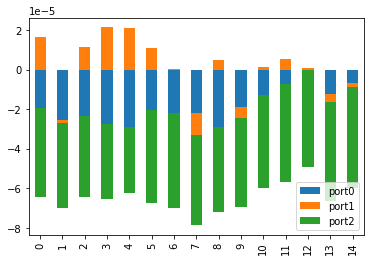

In [85]:
output["sim6"]['result']['to_0.02_tr_0.1']['theta'].plot.bar(stacked=True)

In [74]:
data_type = "train"
start = dt.datetime(1995, 1, 1)
end = dt.datetime(2020, 1, 1)
df_port_org = output["sim6"]["port_" + data_type]

port_pattern = output["sim6"]['result']['to_0.02_tr_0.1']

fig1 = plot_return(df_port_org, start, end, data_type)
fig2 = plot_lrp(start, end, port_lrp_dict, data_type, factor_category_dict)
fig1.show()
fig2.show()